## Pupil detection

### 1. Imports

In [22]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [23]:
base_folder = 'data/artificial'
base_filename = 'base2'
base_extension = 'jpeg'
base_filepath = os.path.join(base_folder, '%s.%s' %
                             (base_filename, base_extension))

print('source: %s' % base_filepath)

source: data/artificial/base2.jpeg


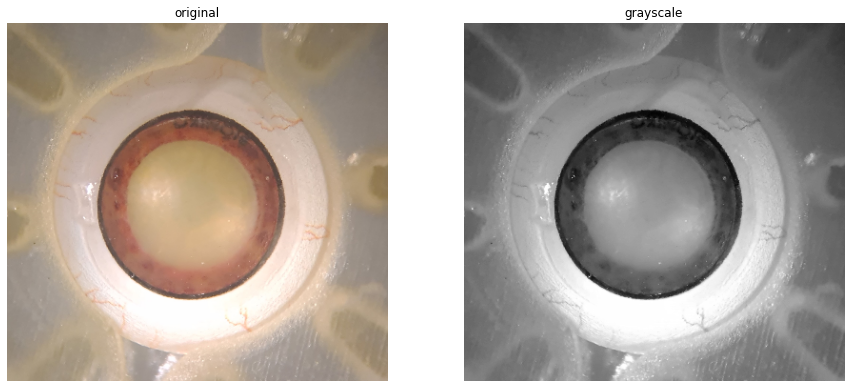

In [24]:
base = cv2.imread(base_filepath, cv2.IMREAD_COLOR)
base = cv2.resize(base, None, fx=0.25, fy=0.25)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 15))
plot1.set_title('original')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plt.show()

### 2. Otsu thresholding on hue, saturation and value channels

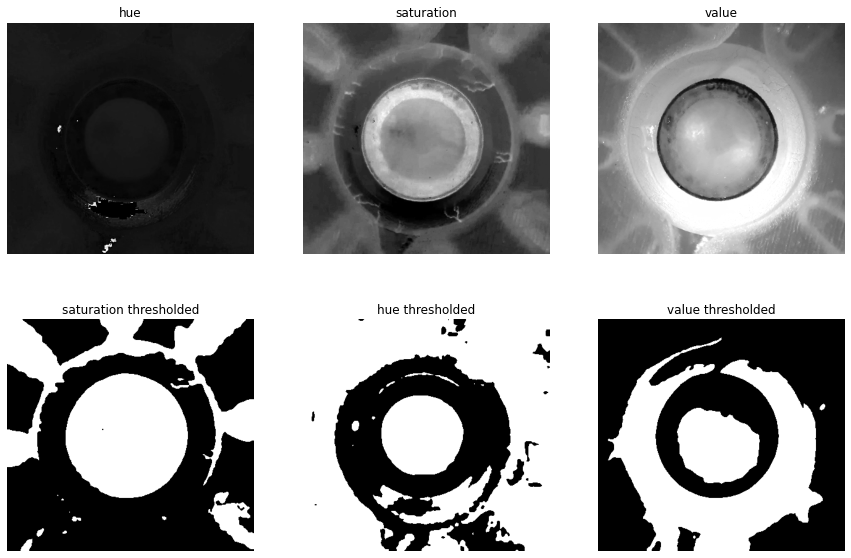

In [25]:
base_hsv_thres = np.zeros(base.shape, dtype=base.dtype)

components = ['hue', 'saturation', 'value']
for i in range(3):
    _, base_otsu = cv2.threshold(
        src=cv2.GaussianBlur(base_hsv[:, :, i], ksize=(0, 0), sigmaX=2),
        thresh=0,
        maxval=255,
        type=cv2.THRESH_OTSU
    )

    base_hsv_thres[:, :, i] = base_otsu

fig, ((plot1, plot2, plot3), (plot4, plot5, plot6)
      ) = plt.subplots(2, 3, figsize=(15, 10))
plot1.set_title('hue')
plot1.imshow(base_hsv[:, :, 0], cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('saturation')
plot2.imshow(base_hsv[:, :, 1], cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('value')
plot3.imshow(base_hsv[:, :, 2], cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation thresholded')
plot4.imshow(base_hsv_thres[:, :, 1], cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('hue thresholded')
plot5.imshow(base_hsv_thres[:, :, 0], cmap=plt.cm.gray)
plot5.axis('off')

plot6.set_title('value thresholded')
plot6.imshow(base_hsv_thres[:, :, 2], cmap=plt.cm.gray)
plot6.axis('off')

plt.show()

Judging from the results above, iris detection based on saturation might be prefered to the one based on value (intensity). Further performance analysis is needed.

### 3. Pupil detection pipeline
1. We detect the limbus using the Hough transform
2. Using the Otsu method, we can detect the pupil
3. Hough circle transform is performed on the thresholded image

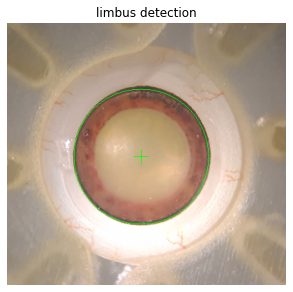

In [26]:
iris_circles = cv2.HoughCircles(
    cv2.GaussianBlur(255 - base_gray, ksize=(0, 0), sigmaX=2),
    cv2.HOUGH_GRADIENT, dp=1, minDist=10,
    param1=120, param2=40,
    minRadius=base_gray.shape[0]//10, maxRadius=base_gray.shape[0]//2
)

iris_best_circle = np.uint16(np.around(iris_circles[0, 0, :]))

base_with_circle = base_rgb.copy()
cv2.circle(base_with_circle,
           (iris_best_circle[0], iris_best_circle[1]), iris_best_circle[2], (0, 255, 0), 1)
cv2.drawMarker(base_with_circle,
               (iris_best_circle[0], iris_best_circle[1]), (0, 255, 0))

fig, plot1 = plt.subplots(1, 1, figsize=(5, 5))
plot1.set_title('limbus detection')
plot1.imshow(base_with_circle)
plot1.axis('off')

plt.show()

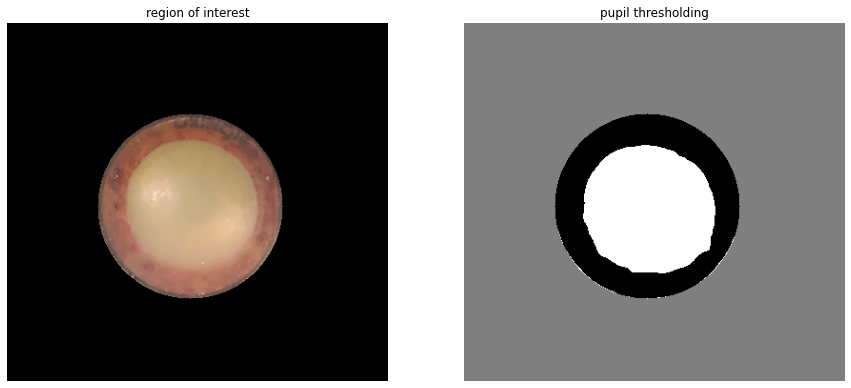

In [27]:
iris_pupil_mask = np.zeros(base.shape[:2], dtype=np.uint8)
cv2.circle(iris_pupil_mask,
           (iris_best_circle[0], iris_best_circle[1]), iris_best_circle[2], 255, cv2.FILLED)

base_gray_blur = cv2.GaussianBlur(base_gray, ksize=(0, 0), sigmaX=2)
base_roi_values = base_gray_blur[np.where(iris_pupil_mask == 255)]
thres_otsu, _ = cv2.threshold(
    src=base_roi_values,
    thresh=0,
    maxval=255,
    type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
)

base_rgb_roi = base_rgb.copy()
base_rgb_roi[np.where(iris_pupil_mask == 0)[0], np.where(
    iris_pupil_mask == 0)[1], :] = [0, 0, 0]

base_gray_roi_thres = base_gray_blur.copy()
base_gray_roi_thres[np.where(base_gray_roi_thres > thres_otsu)] = 255
base_gray_roi_thres[np.where(base_gray_roi_thres <= thres_otsu)] = 0
base_gray_roi_thres[np.where(iris_pupil_mask == 0)[
    0], np.where(iris_pupil_mask == 0)[1]] = 255//2

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 15))
plot1.set_title('region of interest')
plot1.imshow(base_rgb_roi)
plot1.axis('off')

plot2.set_title('pupil thresholding')
plot2.imshow(base_gray_roi_thres, cmap=plt.cm.gray)
plot2.axis('off')

plt.show()

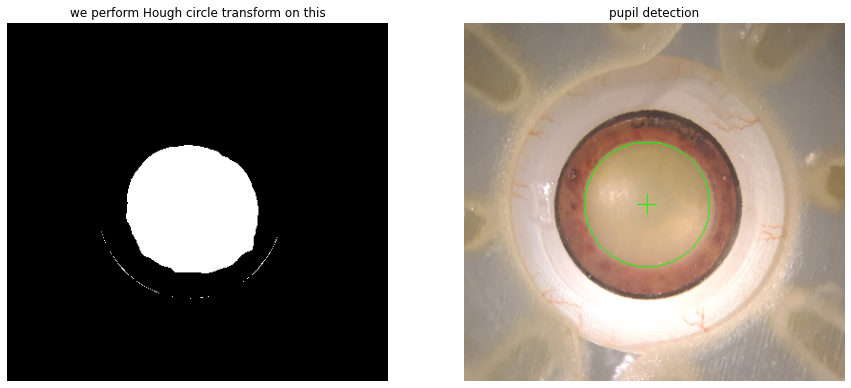

In [28]:
base_pupil_gray = base_gray_blur.copy()
base_pupil_gray[np.where(base_gray_roi_thres > thres_otsu)] = 255
base_pupil_gray[np.where(base_gray_roi_thres <= thres_otsu)] = 0
base_pupil_gray[np.where(iris_pupil_mask == 0)[0],
                np.where(iris_pupil_mask == 0)[1]] = 0
pupil_circles = cv2.HoughCircles(
    cv2.GaussianBlur(base_pupil_gray, ksize=(0, 0), sigmaX=2),
    cv2.HOUGH_GRADIENT, dp=1, minDist=10,
    param1=120, param2=40,
    minRadius=base_pupil_gray.shape[0]//10, maxRadius=base_pupil_gray.shape[0]//2
)

pupil_best_circle = np.uint16(np.around(pupil_circles[0, 0, :]))

base_with_circle = base_rgb.copy()
cv2.circle(base_with_circle,
           (pupil_best_circle[0], pupil_best_circle[1]), pupil_best_circle[2], (0, 255, 0), 1)
cv2.drawMarker(base_with_circle,
               (pupil_best_circle[0], pupil_best_circle[1]), (0, 255, 0))

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 15))
plot1.set_title('we perform Hough circle transform on this')
plot1.imshow(base_pupil_gray, cmap='gray')
plot1.axis('off')

plot2.set_title('pupil detection')
plot2.imshow(base_with_circle)
plot2.axis('off')

plt.show()

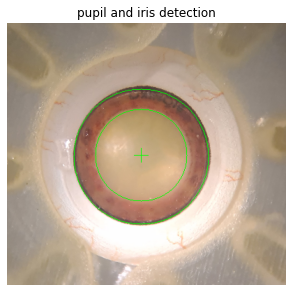

In [29]:
base_with_circle = base_rgb.copy()
cv2.circle(base_with_circle,
           (iris_best_circle[0], iris_best_circle[1]), iris_best_circle[2], (0, 255, 0), 1)
cv2.circle(base_with_circle,
           (pupil_best_circle[0], pupil_best_circle[1]), pupil_best_circle[2], (0, 255, 0), 1)
cv2.drawMarker(base_with_circle,
               (pupil_best_circle[0], pupil_best_circle[1]), (0, 255, 0))

fig, plot1 = plt.subplots(1, 1, figsize=(5, 5))
plot1.set_title('pupil and iris detection')
plot1.imshow(base_with_circle)
plot1.axis('off')

plt.show()

### 4. Anatomy segmentation masks

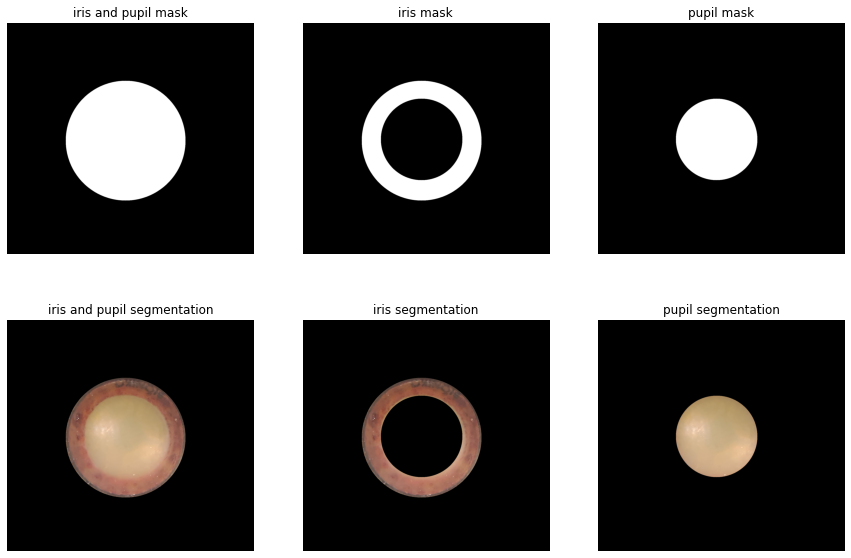

In [30]:
base_original = cv2.imread(base_filepath, cv2.IMREAD_COLOR)

iris_pupil_mask = np.zeros(base_original.shape[:2], dtype=np.uint8)
cv2.circle(iris_pupil_mask,
           (4*iris_best_circle[0], 4*iris_best_circle[1]), 4*iris_best_circle[2], 255, cv2.FILLED)

iris_mask = np.zeros(base_original.shape[:2], dtype=np.uint8)
cv2.circle(iris_mask, (4*iris_best_circle[0], 4 *
           iris_best_circle[1]), 4*iris_best_circle[2], 255, cv2.FILLED)
cv2.circle(iris_mask, (4*pupil_best_circle[0], 4 *
           pupil_best_circle[1]), 4*pupil_best_circle[2], 0, cv2.FILLED)

pupil_mask = np.zeros(base_original.shape[:2], dtype=np.uint8)
cv2.circle(pupil_mask, (4*pupil_best_circle[0], 4 *
           pupil_best_circle[1]), 4*pupil_best_circle[2], 255, cv2.FILLED)

base_iris_pupil = base_original.copy()
base_iris_pupil[np.where(iris_pupil_mask == 0)[0], np.where(
    iris_pupil_mask == 0)[1], :] = [0, 0, 0]

base_iris = base_original.copy()
base_iris[np.where(iris_mask == 0)[0], np.where(
    iris_mask == 0)[1], :] = [0, 0, 0]

base_pupil = base_original.copy()
base_pupil[np.where(pupil_mask == 0)[0], np.where(
    pupil_mask == 0)[1], :] = [0, 0, 0]

# visualization
fig, ((plot1, plot2, plot3), (plot4, plot5, plot6)
      ) = plt.subplots(2, 3, figsize=(15, 10))
plot1.set_title('iris and pupil mask')
plot1.imshow(iris_pupil_mask, cmap=plt.cm.gray)
plot1.axis('off')

plot2.set_title('iris mask')
plot2.imshow(iris_mask, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('pupil mask')
plot3.imshow(pupil_mask, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('iris and pupil segmentation')
plot4.imshow(cv2.cvtColor(base_iris_pupil, cv2.COLOR_BGR2RGB))
plot4.axis('off')

plot5.set_title('iris segmentation')
plot5.imshow(cv2.cvtColor(base_iris, cv2.COLOR_BGR2RGB))
plot5.axis('off')

plot6.set_title('pupil segmentation')
plot6.imshow(cv2.cvtColor(base_pupil, cv2.COLOR_BGR2RGB))
plot6.axis('off')


plt.show()

### 5. Saving the results (optional)

In [ ]:
destination = os.path.join(
    base_folder, '%s_iris_and_pupil_mask.png' % base_filename)
cv2.imwrite(destination, iris_pupil_mask)

destination = os.path.join(base_folder, '%s_iris_mask.png' % base_filename)
cv2.imwrite(destination, iris_mask)

destination = os.path.join(base_folder, '%s_pupil_mask.png' % base_filename)
cv2.imwrite(destination, pupil_mask)

destination = os.path.join(
    base_folder, '%s_iris_and_pupil.png' % base_filename)
cv2.imwrite(destination, base_iris_pupil)

destination = os.path.join(base_folder, '%s_iris.png' % base_filename)
cv2.imwrite(destination, base_iris)

destination = os.path.join(base_folder, '%s_pupil.png' % base_filename)
cv2.imwrite(destination, base_pupil)